In [10]:
#Importing packages we need
import numpy as np
import matplotlib.pyplot as plt #pyplot is used to plot the data
import scipy.optimize as opt #used to numerically optimize
from datetime import time, timedelta, datetime
import pandas as pd

In [2]:
def GaussianDensity(y,m,s):
    return np.exp(-0.5*np.log(np.pi)-0.5*np.log(s)-0.5*((y-m)**2)/s)

In [3]:
#getting data
#Locate my folder
#folder='e/august/code/jupyter/Markov/Finance A examples/' #remember it is written with "/" seperators like 'C:/Users/...' 
data=np.genfromtxt('SP500.csv', delimiter=',',usecols=np.arange(0,4)) #loading in first 4 columns
y = data[15097:, 3:4]*100 # 100 times log-returns of the S&P 500 index. January 4, 2010 - till end
y=y.T[0,:] #unpacking numpy array
T = len(y) #length of time series

In [4]:
def likelihood(gamma):
    #parameters
    p00    = gamma[0]
    p11    = gamma[1]
    sigma2 = gamma[2:4]**2;
    T      = len(y)
    #//transition matrix
    P = np.zeros([2,2])
    P[0]=p00, 1-p11
    P[1]=1-p00, p11
    
    #//bookkeeping
    xi_10      = np.zeros([2,T+1])
    xi_11      = np.zeros([2,T])
    xi_1T      = np.zeros([2,T])
    lik        = np.zeros(T)

    #//regression:
    A  = np.vstack(((np.identity(2)-P),np.ones([1,2])))
    pi_first = np.linalg.inv(A.T.dot(A)).dot(A.T)
    pi_second=np.vstack((np.zeros([2,1]),np.ones([1,1])))
    pi=pi_first.dot(pi_second)
    xi_10[[0,1],0] = pi.T
    #//forward filter recursion
    eta=np.zeros(2)
    for t in range(T):
        #//state densities
        eta[0]=GaussianDensity(y[t],0,sigma2[0])
        eta[1]=GaussianDensity(y[t],0,sigma2[1])
        
        #likelihood
        #print(np.log(xi_10[[0,1],t]))
        lik[t]   = np.log(xi_10[0,t]*eta[0]+xi_10[1,t]*eta[1])
        
        #filtering
        num0=eta[0]*xi_10[0,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
        num1=eta[1]*xi_10[1,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
        xi_11[[0,1],t] = num0,num1

        #prediction
        xi_10[[0,1],t+1] = P.dot(xi_11[[0,1],t])
    return -np.sum(lik) #We wish to minimize the likelihood in our scipy opt function

In [12]:
sigma2 = np.var(y) #used for initial guesses for sigma2 vals
Gamma0  =np.array([0.95,0.95,np.sqrt(2*sigma2),np.sqrt(0.5*sigma2)]) #initial guesses
res=opt.minimize(likelihood, Gamma0, method='L-BFGS-B',bounds=((0.001,0.9999),(0.001,0.9999),(0.01,None),(0.01,None))) #optimizing. We use L-BFGS-B as it allows for bounds and can compute the standard errors (from the inverse hessian) right away
res.x
v_hessian=res.hess_inv.todense() #retrieves the negative inverse hessian matrix (note we have minimized the negative log likelihood function)
se_hessian=np.sqrt(np.diagonal(v_hessian))
print(np.sqrt(2*sigma2),np.sqrt(0.5*sigma2))

1.4212216740086476 0.7106108370043238


In [6]:
#result of optimization
Gamma_hat=res.x
se=se_hessian
print('P11='+str(Gamma_hat[0])+', std.errors='+str(se[0]))
print('P22='+str(Gamma_hat[1])+', std.errors='+str(se[1]))
print('h1='+str(Gamma_hat[2])+', std.errors='+str(se[2]))
print('h2='+str(Gamma_hat[3])+', std.errors='+str(se[3]))

P11=0.9667809908570149, std.errors=0.09956987005987049
P22=0.9920764897886318, std.errors=0.019708606966657622
h1=1.7488356405184289, std.errors=0.46771163979309915
h2=0.7258489024809038, std.errors=0.1706862739971771


In [7]:
#Plotting returns and filtered probabilities
gamma=Gamma_hat
#parameters
p00    = gamma[0]
p11    = gamma[1]
sigma2 = gamma[2:4]**2;
T      = len(y)
#//transition matrix
P = np.zeros([2,2])
P[0]=p00, 1-p11
P[1]=1-p00, p11
    
#//bookkeeping
xi_10      = np.zeros([2,T+1])
xi_11      = np.zeros([2,T])
xi_1T      = np.zeros([2,T])
lik        = np.zeros(T)

#//regression:
A  = np.vstack(((np.identity(2)-P),np.ones([1,2])))
pi_first = np.linalg.inv(A.T.dot(A)).dot(A.T)
pi_second=np.vstack((np.zeros([2,1]),np.ones([1,1])))
pi=pi_first.dot(pi_second)
xi_10[[0,1],0] = pi.T
#//forward filter recursion
eta=np.zeros(2)
for t in range(T):
    #//state densities
    eta[0]=GaussianDensity(y[t],0,sigma2[0])
    eta[1]=GaussianDensity(y[t],0,sigma2[1])
        
    #likelihood
    #print(np.log(xi_10[[0,1],t]))
    lik[t]   = np.log(xi_10[0,t]*eta[0]+xi_10[1,t]*eta[1])
        
    #filtering
    num0=eta[0]*xi_10[0,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
    num1=eta[1]*xi_10[1,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
    xi_11[[0,1],t] = num0,num1

    #prediction
    xi_10[[0,1],t+1] = P.dot(xi_11[[0,1],t])
    
    #Backward smoother (not needed for likelihood)
    xi_1T[:,T-1]=xi_11[:,T-1]
    for t in range(T-2,0,-1):
        xi_1T[:,t]=xi_11[:,t]*(P.T.dot(xi_1T[:,t+1]/xi_10[:,t+1]))
        
vol=np.zeros(len(y))
for i in range(T):
    vol[i]=xi_11[[0],i]*sigma2[0]+ (1-xi_11[[0],i])*sigma2[1]

/tmp/ipykernel_217686/2850974356.py:47: RuntimeWarning: invalid value encountered in divide
  xi_1T[:,t]=xi_11[:,t]*(P.T.dot(xi_1T[:,t+1]/xi_10[:,t+1]))
/tmp/ipykernel_217686/2850974356.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol[i]=xi_11[[0],i]*sigma2[0]+ (1-xi_11[[0],i])*sigma2[1]


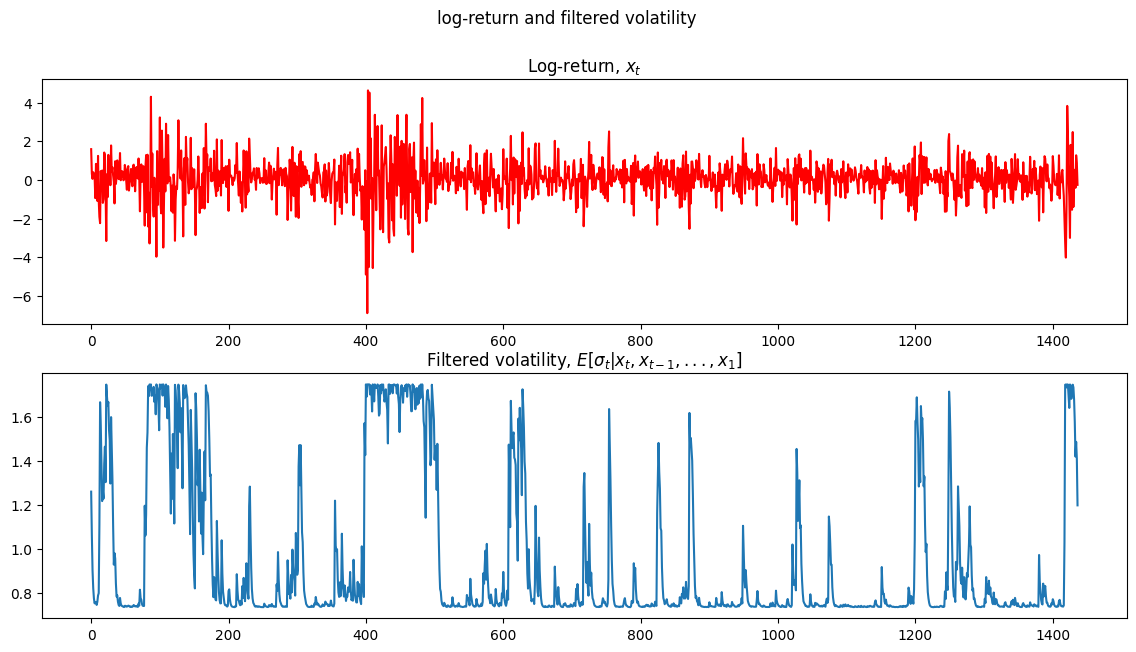

In [8]:
fig, ax=plt.subplots(2, figsize=(14,7))
#fig.set_figheight=(9)
#fig.set_figwidth=(16)
fig.suptitle('log-return and filtered volatility')
ax[0].plot(y,color='r')
ax[1].plot(np.sqrt(vol))

#Setting titles
ax[0].title.set_text('Log-return, $x_t$')
ax[1].title.set_text('Filtered volatility, $E[\sigma_t|x_t,x_{t-1},...,x_1]$')


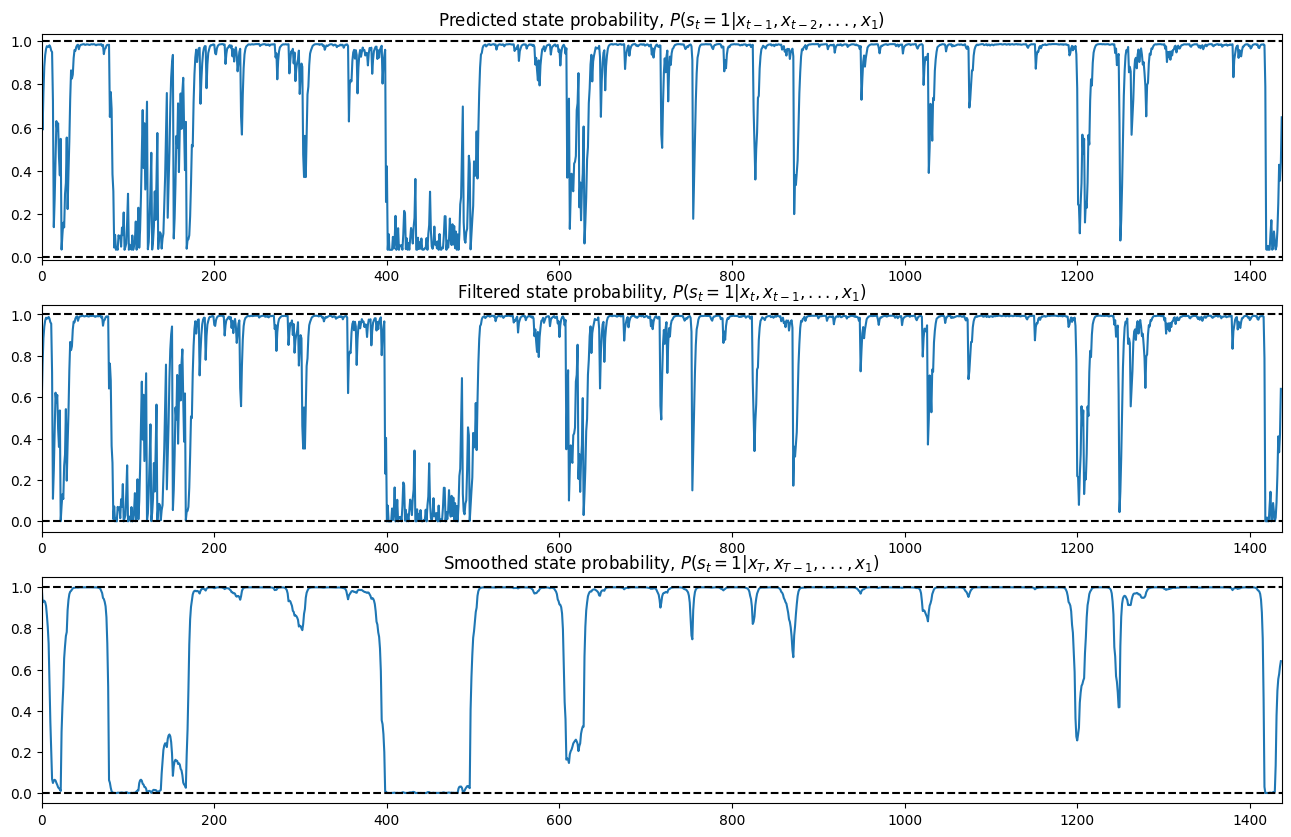

In [9]:
#Predicted state probability, Filtered state probability and smoothed state probability
fig, ax=plt.subplots(3, figsize=(16,9))
#fig.tight_layout() 

#Adjusting size between subplots
fig.subplots_adjust(left=None, bottom=0.025, right=None, top=None, wspace=None, hspace=None)
#default
#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots


ax[0].plot(1-xi_10[0,:])
ax[1].plot(1-xi_11[0,:])
ax[2].plot(1-xi_1T[0,:])

#Setting limits on x axis
ax[0].set_xlim(0, T)
ax[1].set_xlim(0, T)
ax[2].set_xlim(0, T)

#Setting titles
ax[0].title.set_text('Predicted state probability, $P(s_t=1|x_{t-1},x_{t-2},...,x_{1})$')
ax[1].title.set_text('Filtered state probability, $P(s_t=1|x_{t},x_{t-1},...,x_{1})$')
ax[2].title.set_text('Smoothed state probability, $P(s_t=1|x_{T},x_{T-1},...,x_{1})$')

#Setting lines at 0 and 1
ax[0].axhline(0,color='black', linestyle="--")
ax[0].axhline(1,color='black', linestyle="--")

ax[1].axhline(0,color='black', linestyle="--")
ax[1].axhline(1,color='black', linestyle="--")

ax[2].axhline(0,color='black', linestyle="--")
ax[2].axhline(1,color='black', linestyle="--")
